# Modeling Iris

## Objective

Classification problem - build a supervised model to predict iris species from their measurments.
***

## Imports

In [15]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import pipeline
from sklearn.metrics import accuracy_score, classification_report
import sklearn.datasets

# Blanket warning filter below.
# Note: this is only for asthetics of the final notebook, these lines should be commented out for development.
import warnings
warnings.filterwarnings('ignore')

***

## Load data

And initial inspection of the dataframe.

In [2]:
# Import data.
iris = sklearn.datasets.load_iris()

# Define feature matrix and response.
feature_matirx = pd.DataFrame(iris.data, columns=iris.feature_names)
response = pd.DataFrame(iris.target, columns=['cls'])

# Inspect.
print('feature matrix shape:  {}\n'.format(feature_matirx.shape))
print('response value counts:\n{}'.format(response.cls.value_counts()))
feature_matirx.head()

feature matrix shape:  (150, 4)

response value counts:
2    50
1    50
0    50
Name: cls, dtype: int64


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


Small dataset do will keep to a small number of folds in cross validation. The classes are balance so no need for stratification in the train_test split and the accuracy score should be a good metric.

Checking for missing values:

In [3]:
feature_matirx.isnull().any()

sepal length (cm)    False
sepal width (cm)     False
petal length (cm)    False
petal width (cm)     False
dtype: bool

And data types:

In [4]:
feature_matirx.dtypes

sepal length (cm)    float64
sepal width (cm)     float64
petal length (cm)    float64
petal width (cm)     float64
dtype: object

In [5]:
response.dtypes

cls    int32
dtype: object

All looks good. Time for some EDA.
***

## EDA

In [6]:
# Combine feature matrix and response (written as species) for easier EDA.
df = feature_matirx.copy()
df['species'] = response['cls'].apply(lambda x: iris.target_names[x])

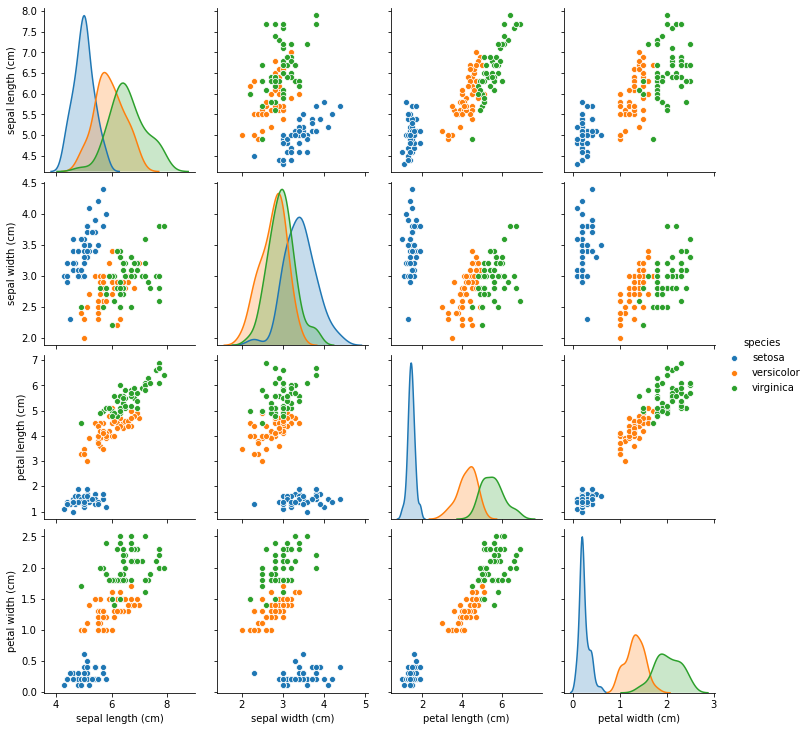

In [7]:
sns.pairplot(df, hue='species');

**Observations:**
* No major outliers.
* Distributions don't look significantly skewed.
* Setosa class look like it has good speparation from the other two classes.
* Versicolor and Virginica class have some overlap.

No need to investigate PCA as the structure is clearly visible and the data doesn't require dimensionality reduction.
***

## Modeling

Accuracy score shall be the main metric for comparing models.  This is suitable as the classes are balanced (if they weren't then recall shouls be used).
<br><br>
### Possible models

**K neares neighbours** -- The classes look like the have ok separation and there is a small dataset with few dimensions.  KNN can be expensive with high dimensionality problems but this is not a problem here.  Also it is unclear if there is a lenear boundry between Versicolor and Virginica so the non-linear KNN may work well.

**Decision tree** -- Worth trying!

**Random forest**  -- Similar to decision trees but less sensitive to outlier / overfitting.  May be over kill here as there doesn't appear to be outliers.

I will check the score for a baseline of each model, with default parameters, then tune the one with the best baseline score with grid search cross validation.

First need to split the data into training ad testing sets:

In [8]:
X_train, X_test, y_train, y_test = train_test_split(feature_matirx, response, random_state=123)

### Basline

In [9]:
# K nearest neighbours.
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print('KNN accuracy score:  {:.3f}\n'.format(accuracy_score(y_test, knn.predict(X_test))))

# Decision tree.
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
print('DTC accuracy score:  {:.3f}\n'.format(accuracy_score(y_test, dtc.predict(X_test))))

# Random forest.
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print('RF accuracy score:  {:.3f}\n'.format(accuracy_score(y_test, rf.predict(X_test))))

KNN accuracy score:  0.974

DTC accuracy score:  0.921

RF accuracy score:  0.947



KNN did very well.  Interesting to see DTC and RF with the same score - perhaps because both use decesion trees and the the small sample size deos not allow for much model diversity in the random forest.

I will select the KNN for tuning.
***

### Hyperparameter optimisation

For this I will use grid search and cross validation.  I will include scalling options in the grid search.  As the dataset is small I can afford a large grid.

In [10]:
pipe = pipeline.make_pipeline(StandardScaler(), KNeighborsClassifier())
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [11]:
# Run grid search and cross validation.
cv_params = {
    'standardscaler__with_mean': [True, False],
    'standardscaler__with_std': [True, False],
    'kneighborsclassifier__n_neighbors': np.arange(1, 50),
}

gridCV = GridSearchCV(pipe, cv_params, cv=3, n_jobs=-1)
gridCV.fit(X_train, y_train)
gridCV.best_params_

{'kneighborsclassifier__n_neighbors': 1,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': False}

It is suggesting that n_neighbors is optimised at 1, which is liely to be very overfited.  I will run a gridsearch again, with optimum scaling results fixed, just varying the n_neigbours and see how the train and test scores relate.

In [12]:
fixed_params = {
    'with_mean': True,
    'with_std': False,
}
pipe2 = pipeline.make_pipeline(StandardScaler(**fixed_params), KNeighborsClassifier())
gridCV = GridSearchCV(
    pipe2, 
    {'kneighborsclassifier__n_neighbors': np.arange(1, 50)}, 
    return_train_score=True, 
    cv=5, 
    n_jobs=-1
)
gridCV.fit(X_train, y_train)
gridCV.best_params_

{'kneighborsclassifier__n_neighbors': 3}

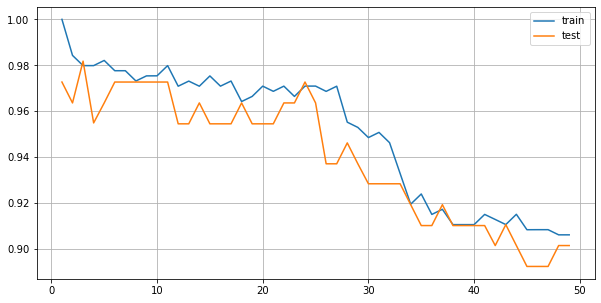

In [13]:
# Gather results in a dataframe.
results = pd.DataFrame(gridCV.cv_results_)

# Plot.
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, 50), results.mean_train_score, label='train')
plt.plot(np.arange(1, 50), results.mean_test_score, label='test')
plt.legend()
plt.grid();

The test set is showing high scores for very small numbers of neighbors, even 1.  This is unusual but may be sure to the very small sample size (the use of cross validation may be limited here).  The pairplot in the EDA seciton above shows very few points that cross over between Versicolor and Virginica - it will be difficult, when spillting the dataset for cross validation to retain a usefull amount of data points in this region.

I will choose n_neighbors as 5 (this was the default in the baseline model), for interest of scalling.  The only difference to the baseline model is substraction of mean.
***

**The final model:**

In [14]:
final_model = pipeline.make_pipeline(StandardScaler(with_std=False), KNeighborsClassifier(n_neighbors=5))
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
print('final model accuracy score:  {:.3f}\n'.format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

final model accuracy score:  0.974

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      0.88      0.93         8
           2       0.93      1.00      0.97        14

    accuracy                           0.97        38
   macro avg       0.98      0.96      0.97        38
weighted avg       0.98      0.97      0.97        38



And save it:

In [16]:
with open('model.pickle', 'wb') as f:
    pickle.dump(final_model, f)

***